In [ ]:
%install '.package(path: "$cwd/FastaiNotebooks")' FastaiNotebooks

Installing packages:
	.package(path: "/home/ubuntu/notebooks/swift/FastaiNotebooks")
		FastaiNotebooks
With SwiftPM flags: []
Working in: /tmp/tmpgiazc1tr
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 1.24s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'FastaiNotebooks' (3 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


In [ ]:
import FastaiNotebooks

## Load the data

In [ ]:
import Path
import TensorFlow

In [ ]:
let mnist = MnistDataset(path: Path.home/".fastai"/"data"/"mnist_tst")

In [ ]:
let x_train = mnist.xTrain.reshaped(toShape: [60_000, 784])

In [ ]:
import Python

In [ ]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
let img = np.array(x_train[0].array.scalars).reshape(28,28)

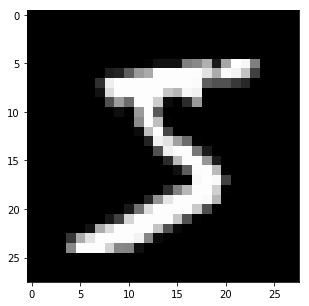

None


In [ ]:
plt.figure(figsize: [5,5])
let fig = plt.imshow(X:img, cmap:"gray")
plt.show(fig)

## Matmul

In [ ]:
var weights = Tensor<Float>(randomNormal: [784, 10]) / sqrt(784)
var bias = Tensor(repeating: 0.0, shape: [10])

### From scratch

Flattened version in pure swift

In [ ]:
func swift_matmul(a:[Float], b:[Float], a_shape:[Int], b_shape:[Int]) -> [Float]{
    var res:[Float] = Array(repeating: 0.0, count: a_shape[0] * b_shape[1])
    for i in 0..<a_shape[0]{
        for j in 0..<b_shape[1]{
            for k in 0..<a_shape[1]{
                res[i + a_shape[0] * j] += a[i + a_shape[0]*k] * b[k + b_shape[0]*j]
            }
        }
    }
    return res
}

In [ ]:
let flat_a = x_train[0..<5].array.scalars
let flat_b = weights.array.scalars

In [ ]:
let res = swift_matmul(a: flat_a, b:flat_b, a_shape:[5,784], b_shape:[784,10])

In [ ]:
time(repeating: 100) { let _ = swift_matmul(a: flat_a, b:flat_b, a_shape:[5,784], b_shape:[784,10])}

0.23574648999999998 ms


With pointers

In [ ]:
func swift_matmul_p(a:[Float], b:[Float], a_shape:[Int], b_shape:[Int]) -> [Float]{
    var res:[Float] = Array(repeating: 0.0, count: a_shape[0] * b_shape[1])
    res.withUnsafeMutableBufferPointer { res_ in
        a.withUnsafeBufferPointer { a_ in
            b.withUnsafeBufferPointer { b_ in                              
                for i in 0..<a_shape[0]{
                    for j in 0..<b_shape[1]{
                        for k in 0..<a_shape[1]{
                            res_[i + a_shape[0] * j] += a_[i + a_shape[0]*k] * b_[k + b_shape[0]*j]
                        }
                    }
                }
            }
        }
    }
    return res
}

In [ ]:
time(repeating: 100) { let _ = swift_matmul_p(a: flat_a, b:flat_b, a_shape:[5,784], b_shape:[784,10])}

0.14843905000000004 ms


With `ShapedArray`

In [ ]:
func sa_matmul(_ a:ShapedArray<Float>, _ b:ShapedArray<Float>) -> ShapedArray<Float>{
    var res:ShapedArray<Float> = ShapedArray(repeating: 0.0, shape: [a.shape[0], b.shape[1]])
    for i in 0..<a.shape[0]{
        for j in 0..<b.shape[1]{
            for k in 0..<a.shape[1]{
                res[i][j].scalar! += a[i][k].scalar! * b[k][j].scalar!
            }
        }
    }
    return res
}

In [ ]:
let m1 = x_train[0..<5]
let m2 = weights

In [ ]:
time() { let res = sa_matmul(m1.array, m2.array)}

3706.764965 ms


With `Tensor`

In [ ]:
func tens_matmul(_ a:Tensor<Float>, _ b:Tensor<Float>) -> Tensor<Float>{
    var res:Tensor<Float> = Tensor(repeating: 0.0, shape: [a.shape[0], b.shape[1]])
    for i in 0..<a.shape[0]{
        for j in 0..<b.shape[1]{
            for k in 0..<a.shape[1]{
                res[i][j] += a[i][k] * b[k][j]
            }
        }
    }
    return res
}

In [ ]:
time() { let res = tens_matmul(m1, m2)}

: 

Too long to execture -> Looping over `ShapedArray` or `Tensor` indices is a bad idea!

#### Elementwise ops

Operators (+,-,\*,/) are usually element-wise.

Examples of element-wise operations:

In [ ]:
var a = Tensor([10.0, 6, -4])
var b = Tensor([2.0, 8, 7])
(a,b)

▿ 2 elements
  - .0 : [10.0, 6.0, -4.0]
  - .1 : [2.0, 8.0, 7.0]


In [ ]:
a + b

[12.0, 14.0, 3.0]


Comparison operators (>,<,==,!=,...) are `true` if all the elements of the tensors satisfy the comparison. Elementwise versions have the . prefix: .>, .<, .== ...

In [ ]:
a < b

false


In [ ]:
a .< b

[false, true, true]


In [ ]:
var m = Tensor([1.0, 2, 3, 4, 5, 6, 7, 8, 9]).reshaped(to: [3,3])
m

[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]


In [ ]:
2 * m

[[2.0, 4.0, 6.0], [8.0, 10.0, 12.0], [14.0, 16.0, 18.0]]


In [ ]:
sqrt((m * m).sum().scalar!)

16.881943016134134


#### Elementwise matmul

In [ ]:
func ew_matmul(_ a:Tensor<Float>, _ b:Tensor<Float>) -> Tensor<Float>{
    var res = Tensor<Float>(zeros: [a.shape[1], b.shape[0]])
    for i in 0..<a.shape[0]{
        for j in 0..<b.shape[1]{
            res[i][j] = (a[i] * b.slice(lowerBounds: [0,j], upperBounds: [a.shape[1],j+1]).squeezingShape(at: 1)).sum()
        }
    }
    return res
}

In [ ]:
let m1 = x_train[0..<5]
let m2 = weights

In [ ]:
let res = ew_matmul(m1, m2)

In [ ]:
time() { let _ = ew_matmul(m1, m2)}

916.92501 ms


### Broadcasting

#### Broadcasting with a scalar

In [ ]:
var a = Tensor([10.0, 6.0, -4.0])

In [ ]:
print(a .> 0)

[true, true, false]


In Tensorflow the operator `>` between tensors will return `true` if all the elements of the first tensor are greater than the ones of the second tensor. `.>` makes the memberwise comparison.

In [ ]:
print(a+1)

[11.0, 7.0, -3.0]


In [ ]:
2 * m

[[2.0, 4.0, 6.0], [8.0, 10.0, 12.0], [14.0, 16.0, 18.0]]


#### Broadcasting a vector with a matrix

In [ ]:
let c = Tensor([10.0,20.0,30.0])

By default, broadcasting is done by adding 1 dimensions to the beginning until dimensions of both objects match.

In [ ]:
m + c

[[11.0, 22.0, 33.0], [14.0, 25.0, 36.0], [17.0, 28.0, 39.0]]


In [ ]:
c + m

[[11.0, 22.0, 33.0], [14.0, 25.0, 36.0], [17.0, 28.0, 39.0]]


To broadcast on the other dimensions, one has to use `expandingShape` to add the dimension.

In [ ]:
m + c.expandingShape(at: 1)

[[11.0, 12.0, 13.0], [24.0, 25.0, 26.0], [37.0, 38.0, 39.0]]


In [ ]:
c.expandingShape(at: 1)

[[10.0], [20.0], [30.0]]


#### Matmult with broadcasting

In [ ]:
func bc_matmul(_ a:Tensor<Float>, _ b:Tensor<Float>) -> Tensor<Float>{
    var res = Tensor<Float>(zeros: [a.shape[1], b.shape[0]])
    for i in 0..<a.shape[0]{
        res[i] = (a[i].expandingShape(at: 1) * b).sum(alongAxes: 1).squeezingShape(at: 1)
    }
    return res
}

In [ ]:
let res = bc_matmul(m1, m2)

In [ ]:
time(repeating: 100) { let _ = bc_matmul(m1, m2)}

27.915051229999996 ms


#### Broadcasting rules

In [ ]:
c.expandingShape(at: 0).shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 1
    - 1 : 3


In [ ]:
c.expandingShape(at: 1).shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 3
    - 1 : 1


In [ ]:
c.expandingShape(at: 0) * c.expandingShape(at: 1)

[[100.0, 200.0, 300.0], [200.0, 400.0, 600.0], [300.0, 600.0, 900.0]]


In [ ]:
c.expandingShape(at: 0) .> c.expandingShape(at: 1)

[[false, true, true], [false, false, true], [false, false, false]]


### Tensorflow op

In [ ]:
time(repeating: 100) { let _ = Raw.matMul(m1, m2)}

0.021464529999999996 ms


### Export

In [ ]:
notebookToScript(fname: (Path.cwd / "01_matmul.ipynb").string)